# Assignment 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import vstack

## 1. Warm-ups

In [ ]:
def shuffle_and_sample(x, y, num_samples, seed):
    stratified_splitter = StratifiedShuffleSplit(n_splits=1,
                                                 train_size=num_samples,
                                                 test_size=10,
                                                 random_state=seed)

    for indices, _ in stratified_splitter.split(x, y):
        return x[indices], y[indices]

In [ ]:
class AdultDataset:
    def __init__(self, seed):
        print("Loading Adult dataset...")
        self.seed = seed

        x, y = fetch_openml(name='a9a', version=1, return_X_y=True)
        n, d = x.shape
        print(f"Number of records: {n}")
        print(f"Number of features: {d}")

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y,
                                                                        test_size=0.25,
                                                                        random_state=self.seed)

    def get_stratified_train_test_split(self, num_train_data, num_test_data, seed):
        x_train, y_train = shuffle_and_sample(self.x_train, self.y_train,
                                              num_samples=num_train_data,
                                              seed=seed)
        x_test, y_test = shuffle_and_sample(self.x_test, self.y_test,
                                            num_samples=num_test_data,
                                            seed=seed)

        return x_train, y_train, x_test, y_test

In [ ]:
class ArceneDataset:
    def __init__(self, seed):
        print("Loading Arcene dataset...")
        self.seed = seed

        x, y = fetch_openml(name='Arcene', version=1, return_X_y=True)
        x, y = np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

        features_complete = ~np.isnan(x).any(axis=0) # features without missing values
        x = x[:, features_complete]

        n, d = x.shape
        print(f"Number of records: {n}")
        print(f"Number of features: {d}")

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y,
                                                                                test_size=0.25,
                                                                                random_state=self.seed)


    def get_stratified_train_test_split(self, num_train_data, num_test_data, seed):
        x_train, y_train = shuffle_and_sample(self.x_train, self.y_train,
                                              num_samples=num_train_data,
                                              seed=seed)
        x_test, y_test = shuffle_and_sample(self.x_test, self.y_test,
                                            num_samples=num_test_data,
                                            seed=seed)

        return x_train, y_train, x_test, y_test

#### Non-private Custom Stochastic Gradient Descent

Acknowledgements: The code for custom SGD has been taken from Aurélien Bellet's privacy preserving machine learning course assignments. Link to the coursepage is [here](http://researchers.lille.inria.fr/abellet/teaching/private_machine_learning_course.html).

In [ ]:
from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin, BaseEstimator
from sklearn.utils.extmath import log_logistic, safe_sparse_dot
from scipy.special import expit
from sklearn.utils.validation import check_X_y

# helper function
def _intercept_dot(w, X, y):
    """Computes y * np.dot(X, w).
    It takes into consideration if the intercept should be fit or not.
    Parameters
    ----------
    w : ndarray, shape (n_features,) or (n_features + 1,)
        Coefficient vector.
    X : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training data.
    y : ndarray, shape (n_samples,)
        Array of labels.
    """
    c = 0.
    if w.size == X.shape[1] + 1:
        c = w[-1]
        w = w[:-1]

    z = safe_sparse_dot(X, w) + c
    return w, c, y * z

In [ ]:
def sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """

    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]

    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    # list to record the evolution of the objective (for plotting)
    obj_list = []

    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)

        # save value of objective function for the last iteration
        if t == (n_iter - 1):
            final_obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])

        # TODO: for epoch t, compute the gradient for each batch and update theta
        g = gamma_func(t)
        for i in range(0, n, n_batch):
          _, grad = obj_and_grad(theta, X[i:(i+n_batch), :], y[i:(i+n_batch)])
          theta = theta - g*grad

    return theta, obj_list, final_obj

In [ ]:
def custom_logistic_obj_and_grad(theta, X, y, lamb):
    """Computes the value and gradient of the objective function of logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = w (if no intercept), or theta = [w b] (if intercept)

    Parameters
    ----------
    theta_init : array, shape (d,) or (d+1,)
        The initial value for the model parameters. When an intercept is used, it corresponds to the last entry
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1)
    lamb : float
        The L2 regularization parameter


    Returns
    -------
    obj : float
        The value of the objective function
    grad : array, shape (d,) or (d+1,)
        The gradient of the objective function
    """
    n_samples, n_features = X.shape
    grad = np.empty_like(theta)

    w, c, yz = _intercept_dot(theta, X, y)

    # Logistic loss is the negative of the log of the logistic function
    obj = -np.mean(log_logistic(yz)) + .5 * lamb * np.dot(w, w)

    z = expit(yz)
    z0 = (z - 1) * y

    grad[:n_features] = safe_sparse_dot(X.T, z0) / n_samples + lamb * w

    # Case where we fit the intercept
    if grad.shape[0] > n_features:
        grad[-1] = z0.sum() / n_samples
    return obj, grad

In [ ]:
class CustomSGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]

    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic

    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """

    def __init__(self, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state

    def fit(self, X, y):
        # check data and convert classes to {-1,1} if needed
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)
        y[y==self.classes_[0]] = -1
        y[y==self.classes_[1]] = 1

        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero

        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: custom_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list, final_obj = sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                                         self.freq_obj_eval, self.n_obj_eval, self.random_state)

        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)

        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list

        # save theta
        self.theta = theta

        # save final objective function value
        self.final_obj = final_obj

        return self

    def update_params(self, new_theta):
        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(new_theta[-1], axis=0)
        self.coef_ = np.expand_dims(new_theta[:-1], axis=0)

Loading Adult dataset...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Number of records: 48842
Number of features: 123
Train dataset size: 5000


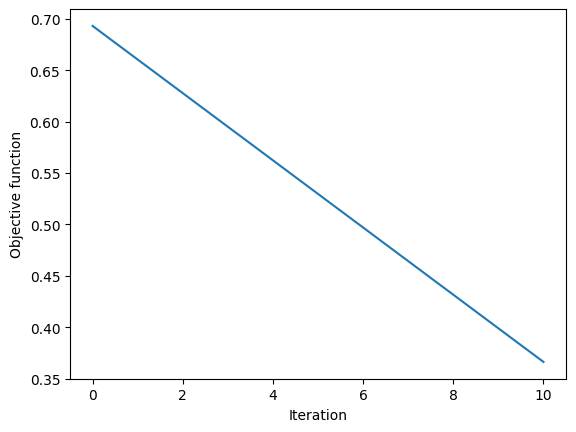

Train dataset size: 10000


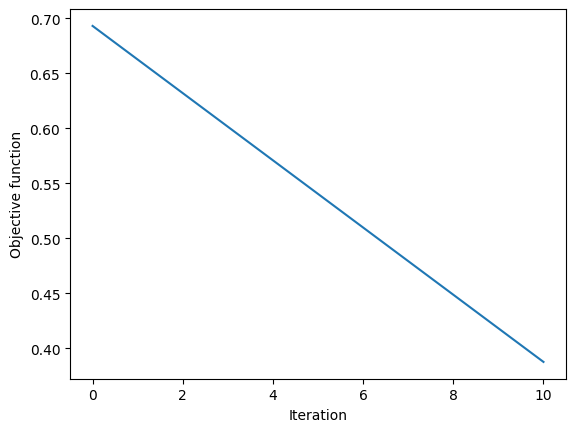

Train dataset size: 20000


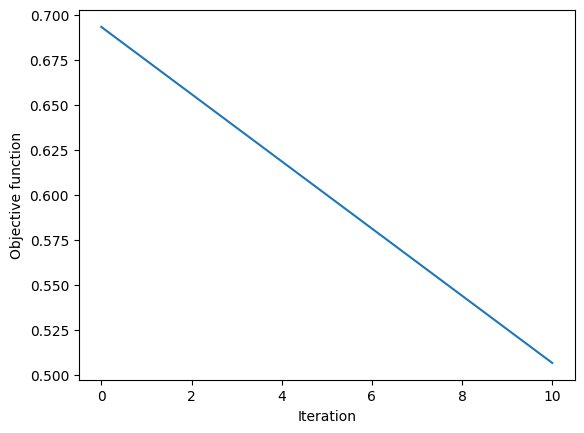

Train dataset size: 30000


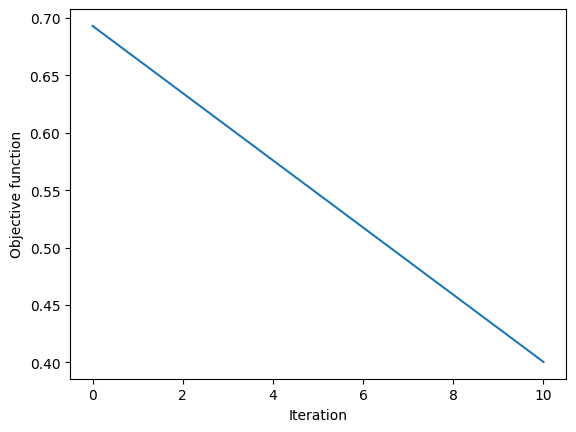

In [ ]:
adult_dataset = AdultDataset(seed=123)
adult_num_train_data_values = [5000, 10000, 20000, 30000]
adult_num_test_data = 1000

sgd_adult_train_accs = []
sgd_adult_test_accs = []
split_seed = 123
for num_train_data in adult_num_train_data_values:
    print(f"Train dataset size: {num_train_data}")
    x_train, y_train, x_test, y_test = adult_dataset.get_stratified_train_test_split(num_train_data,
                                                                                     adult_num_test_data,
                                                                                     seed=split_seed)

    lamb = 0
    n_iter = 20
    n_batch = 1
    gamma = 0.25
    # gamma = lambda t: 1 / np.sqrt(t)

    model = CustomSGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
    model.fit(x_train, y_train)

    obj_list = model.obj_list_
    iter_list = np.arange(len(obj_list)) * model.freq_obj_eval
    plt.plot(iter_list, obj_list)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function")
    plt.show()

    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)

    sgd_adult_train_accs.append(train_acc)
    sgd_adult_test_accs.append(test_acc)

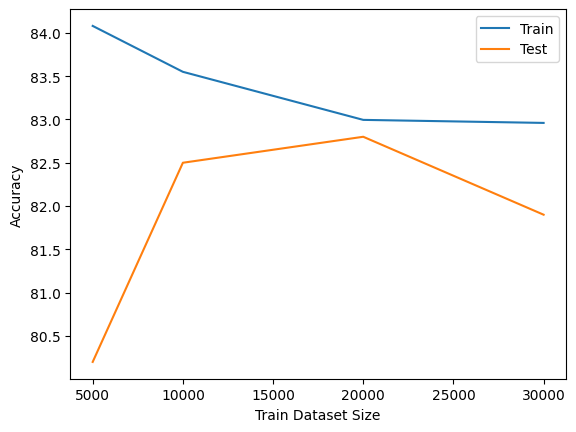

In [ ]:
# TODO: plot train and test accuracy per dataset size
plt.plot(adult_num_train_data_values, [a*100 for a in sgd_adult_train_accs], label = "Train")
plt.plot(adult_num_train_data_values, [a*100 for a in sgd_adult_test_accs], label = "Test")
plt.ylabel("Accuracy")
plt.xlabel("Train Dataset Size")
plt.legend()
plt.show()

## 2. Private Training via DP-SGD

### 2.1 DP-SGD

In [ ]:
def dp_sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
           n_obj_eval=1000, clipping_norm=None, noise_multiplier=None, random_state=None,
           plot=False):
    """Differentially Private Stochastic Gradient Descent (DP-SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """

    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]

    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    # list to record the evolution of the objective (for plotting)
    obj_list = []

    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    # list to save gradients for batch=1
    true_grads = []
    privatized_grads = []
    batch_num = 0

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)

            print(f"Value of objective function at iteration {t}: {obj}")

        # save value of objective function for the last iteration
        if t == (n_iter - 1):
            final_obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])

        # TODO: compute the gradient, clip it
        g = gamma_func(t)
        for i in range(0, n, n_batch):
          _, grad = obj_and_grad(theta, X[i:(i+n_batch), :], y[i:(i+n_batch)])
          if i == batch_num:
            true_grads.append(grad)

          grad = grad / max(1, np.linalg.norm(grad, 2)/clipping_norm)

          # TODO: compute the noisy gradient for each batch and update theta
          noise = np.random.normal(0, (noise_multiplier * clipping_norm), grad.shape)
          grad = (grad + noise) / n_batch
          if i == batch_num:
            privatized_grads.append(grad)

          theta = theta - g*grad

    # Plotting functions for Question 2.3
    if plot:
      plot_grads_trajectory(true_grads, privatized_grads, clipping_norm)

    return theta, obj_list, final_obj

In [ ]:
class CustomPrivateSGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]

    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic

    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """

    def __init__(self, gamma, n_iter, lamb=0, n_batch=1,
                 freq_obj_eval=10, n_obj_eval=1000,
                 clipping_norm=None, noise_multiplier=None,
                 random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.clipping_norm = clipping_norm
        self.noise_multiplier = noise_multiplier
        self.random_state = random_state

    def fit(self, X, y):
        # check data and convert classes to {-1,1} if needed
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)
        y[y==self.classes_[0]] = -1
        y[y==self.classes_[1]] = 1

        p = X.shape[1]
        theta_init = np.zeros(p + 1) # initialize parameters to zero

        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: custom_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list, final_obj = dp_sgd(X, y, self.gamma, self.n_iter, obj_grad,
                                                theta_init, self.n_batch,
                                                self.freq_obj_eval, self.n_obj_eval,
                                                self.clipping_norm, self.noise_multiplier,
                                                self.random_state)

        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)

        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list

        # save theta
        self.theta = theta

        # save final objective function value
        self.final_obj = final_obj

        return self

    def update_params(self, new_theta):
        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(new_theta[-1], axis=0)
        self.coef_ = np.expand_dims(new_theta[:-1], axis=0)

Loading Adult dataset...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Number of records: 48842
Number of features: 123
Train dataset size: 10000
Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.37794510302892126


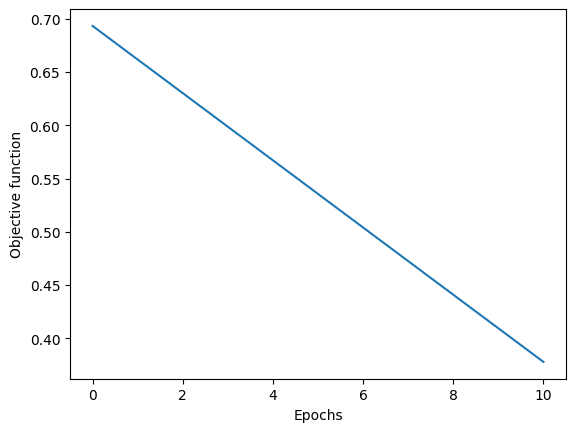

In [ ]:
# TODO: train a private logistic regression model using DP-SGD with noise and clipping
adult_dataset = AdultDataset(seed=123)
adult_num_train_data = 10000
adult_num_test_data = 1000

dp_sgd_adult_train_accs = []
dp_sgd_adult_test_accs = []
split_seed = 123

print(f"Train dataset size: {adult_num_train_data}")
x_train, y_train, x_test, y_test = adult_dataset.get_stratified_train_test_split(adult_num_train_data,
                                                                                    adult_num_test_data,
                                                                                    seed=split_seed)

lamb = 0
n_iter = 20
n_batch = 1
gamma = 0.25
# gamma = lambda t: 1 / np.sqrt(t)
clipping_norm = 1.0
noise_multiplier = 0.05

model = CustomPrivateSGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch,
                                            clipping_norm=clipping_norm,
                                            noise_multiplier=noise_multiplier,
                                            random_state=None)
model.fit(x_train, y_train)

obj_list = model.obj_list_
iter_list = np.arange(len(obj_list)) * model.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Epochs")
plt.ylabel("Objective function")
plt.show()

train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)

dp_sgd_adult_train_accs.append(train_acc)
dp_sgd_adult_test_accs.append(test_acc)

In [ ]:
print(f'Train data size: {adult_num_train_data} \nTrain accuracy: {dp_sgd_adult_train_accs[0]*100} \nTest accuracy: {dp_sgd_adult_test_accs[0]*100}')

Train data size: 10000 
Train accuracy: 84.22 
Test accuracy: 82.39999999999999


### 2.3 Effect of Clipping Norm on Accuracy

Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.4902716899849306


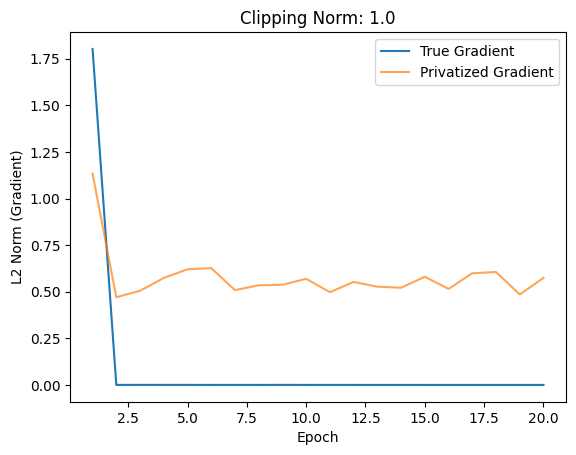

(array([-1.374236  ,  2.34911746,  3.01015647,  3.8166801 ,  3.32919348,
        -1.54468118, -2.98106794,  0.18899191, -0.51651256, -1.16094976,
        -2.56035135,  3.02967401,  6.39569359, -4.80879416, -3.36539452,
        -4.11931729, -3.90549504, -4.38403254,  1.3788123 , -3.13802926,
         3.26947282,  1.52156766,  4.09746195,  0.40438782, -0.22199235,
         4.14198075,  0.58563619,  2.3413004 ,  2.1223202 ,  1.97821856,
         4.42581376,  2.58638419,  6.37717784, -1.86888686, -8.42364521,
        -4.86286616,  0.89007584, -1.27349766, -2.38091407,  0.47041101,
        -3.39916243, -3.58227197, -4.5496471 , -2.26464787, -3.7826667 ,
         0.40226894,  4.71189109,  2.66778812, -1.15349532,  3.88901325,
         4.97934295,  4.14822726,  0.73202187,  3.1285005 ,  2.97907452,
         2.13130028,  1.58307209,  4.08489416,  1.61981013,  7.0547021 ,
         4.95902582, -0.51261039,  1.40365466,  1.0730555 , -1.25587009,
         0.37646775,  2.32590675, -1.44487903, -0.4

In [ ]:
# TODO: compute and store the true and privatized gradient for multiple epochs, plot them
def plot_grads_trajectory(true_grads, privatized_grads, clipping_norm):
  x = [(i+1) for i in range(20)]
  true_gradients = [np.linalg.norm(grad, 2) for grad in true_grads]
  privatized_gradients = [np.linalg.norm(grad, 2) for grad in privatized_grads]

  plt.plot(x, true_gradients, label='True Gradient')
  plt.plot(x, privatized_gradients, label='Privatized Gradient', alpha=0.7)
  plt.xlabel('Epoch')
  plt.ylabel('L2 Norm (Gradient)')
  plt.title(f'Clipping Norm: {clipping_norm}')
  plt.legend()
  plt.show()


# check data and convert classes to {-1,1} if needed
X, y = check_X_y(x_train, y_train, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
classes = np.unique(y)
y[y==classes[0]] = -1
y[y==classes[1]] = 1
p = X.shape[1]
theta_init = np.zeros(p + 1) # initialize parameters to zero
# define the function for value and gradient needed by SGD
obj_grad = lambda theta, X, y: custom_logistic_obj_and_grad(theta, X, y, lamb=lamb)

clipping_norm = 1.0

dp_sgd(X, y, gamma, n_iter, obj_grad, theta_init, n_batch, 10, 1000, clipping_norm, noise_multiplier, plot=True)

Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.6433202973319069


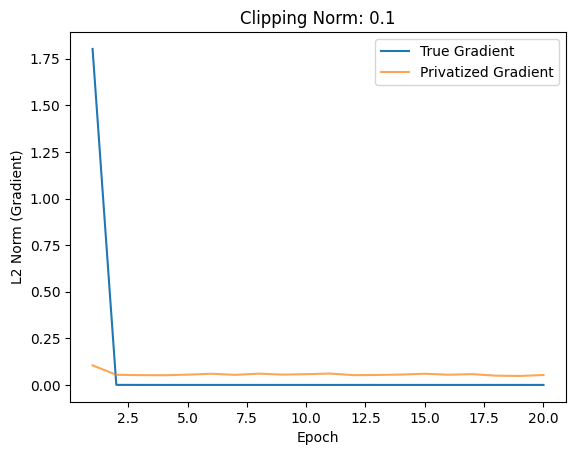

Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.46624046261212726


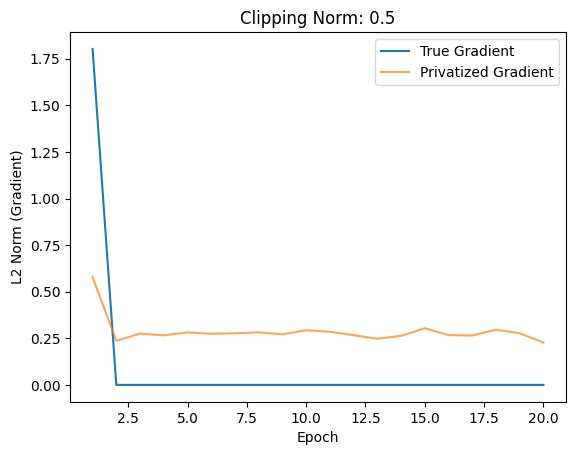

Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.4148882444364262


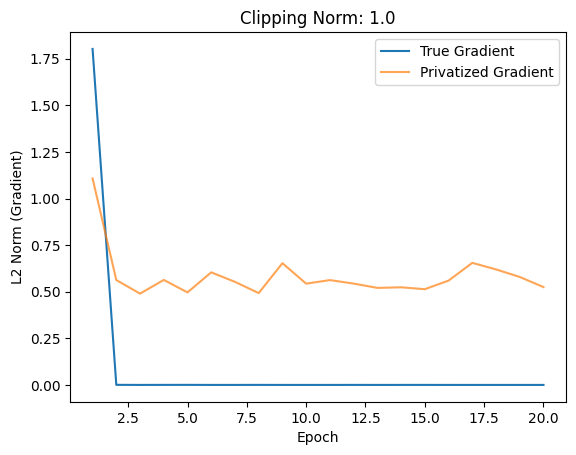

Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.5720957276279784


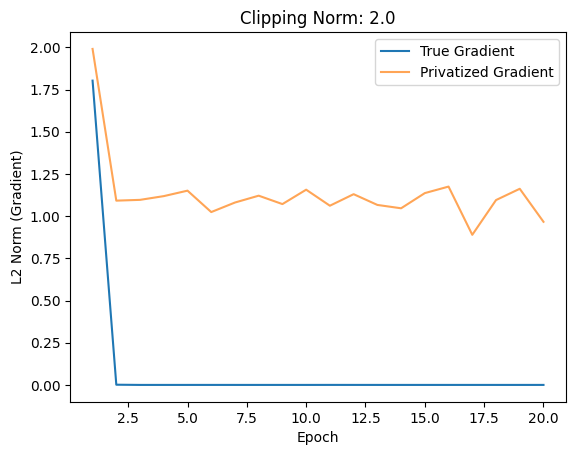

In [ ]:
# TODO: repeat the experiment for different values of the clipping norm
dp_sgd_adult_train_accs = []
dp_sgd_adult_test_accs = []

lamb = 0
n_iter = 20
n_batch = 1
gamma = 0.25
# gamma = lambda t: 1 / np.sqrt(t)
noise_multiplier = 0.05
C = [0.1, 0.5, 1.0, 2.0]

for clipping_norm in C:
  model = CustomPrivateSGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch,
                                            clipping_norm=clipping_norm,
                                            noise_multiplier=noise_multiplier,
                                            random_state=None)
  model.fit(x_train, y_train)

  train_acc = model.score(x_train, y_train)
  test_acc = model.score(x_test, y_test)

  dp_sgd_adult_train_accs.append(train_acc)
  dp_sgd_adult_test_accs.append(test_acc)

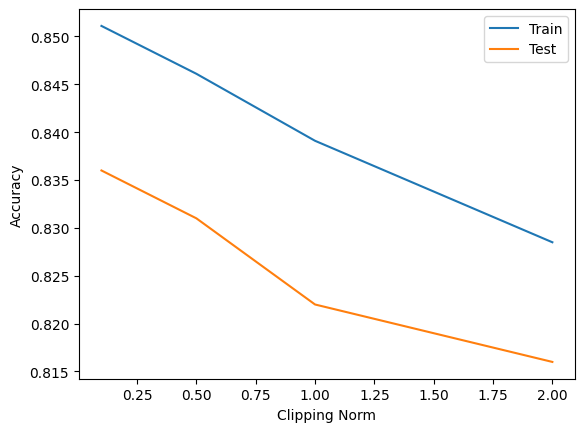

In [ ]:
plt.plot(C, dp_sgd_adult_train_accs, label='Train')
plt.plot(C, dp_sgd_adult_test_accs, label='Test')
plt.xlabel('Clipping Norm')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. Membership inference on DP models

In [ ]:
adult_dataset = AdultDataset(seed=123)
adult_num_train_data = 10000
adult_num_test_data = 1000

split_seed=123

x_train, y_train, x_test, y_test = adult_dataset.get_stratified_train_test_split(adult_num_train_data,
                                                                                     adult_num_test_data,
                                                                                     seed=split_seed)

x_target = x_test[0]
y_target = y_test[0]

Loading Adult dataset...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Number of records: 48842
Number of features: 123


Training iteration:  1
Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.4110941631863736
Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.46776668900163654
Training iteration:  2
Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.49729332775129276
Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.43635462364319544
Training iteration:  3
Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.4313673792056817
Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.4999358940792531
Training iteration:  4
Value of objective function at iteration 0: 0.6931471805599454
Value of objective function at iteration 10: 0.4638214764180059
Value of objecti

(array([9., 7., 1., 0., 1., 0., 0., 1., 0., 1.]),
 array([2.80045669e-05, 3.50709698e-04, 6.73414828e-04, 9.96119959e-04,
        1.31882509e-03, 1.64153022e-03, 1.96423535e-03, 2.28694048e-03,
        2.60964561e-03, 2.93235074e-03, 3.25505587e-03]),
 <BarContainer object of 10 artists>)

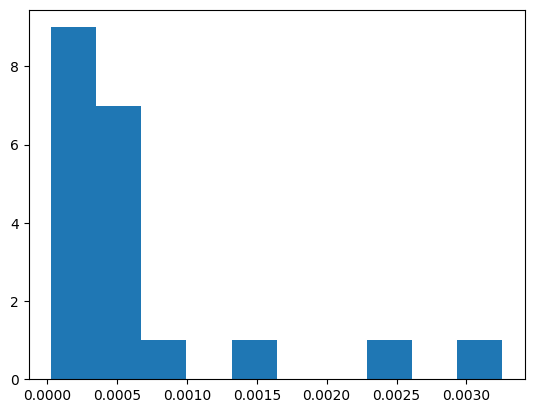

In [ ]:
# Compute a member model and a non-member model, and return the loss of the target point

def compute_in_out_loss_for_target(x_train, y_train, x_target, y_target):
    # load the two datasets
    seed = 555
    x_train_member = vstack([x_train, x_target]).toarray()
    y_train_member = np.append(y_train, [y_target])

    # hyperparameters
    lamb = 0
    n_iter = 20
    n_batch = 1
    gamma = 0.25
    # gamma = lambda t: 1 / np.sqrt(t)
    clipping_norm = 1.0
    noise_multiplier = 0.05

    # initialize two models
    model_nonmember = CustomPrivateSGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch,
                                               clipping_norm=clipping_norm,
                                               noise_multiplier=noise_multiplier,
                                               random_state=None)
    model_member = CustomPrivateSGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch,
                                               clipping_norm=clipping_norm,
                                               noise_multiplier=noise_multiplier,
                                               random_state=None)

    # TODO: train the two models and compute loss of the two models on the target point x_target, y_target
    model_nonmember.fit(x_train, y_train)
    loss_nonmember, _ = custom_logistic_obj_and_grad(model_nonmember.theta, x_target, y_target, lamb)

    model_member.fit(x_train_member, y_train_member)
    loss_member, _ = custom_logistic_obj_and_grad(model_member.theta, x_target, y_target, lamb)

    return loss_nonmember, loss_member


# TODO: train 10 rounds and compute the loss histogram for member and non-member, store the vector of ground truth labels (each element of the vector takes value of 0 or 1)
hist = []
member_label =[]

for i in range(10):
  print("Training iteration: ", i+1)
  loss_nonmember, loss_member = compute_in_out_loss_for_target(x_train, y_train, x_target, y_target)

  hist.append(loss_nonmember)
  member_label.append(0)
  hist.append(loss_member)
  member_label.append(1)

plt.hist(hist)

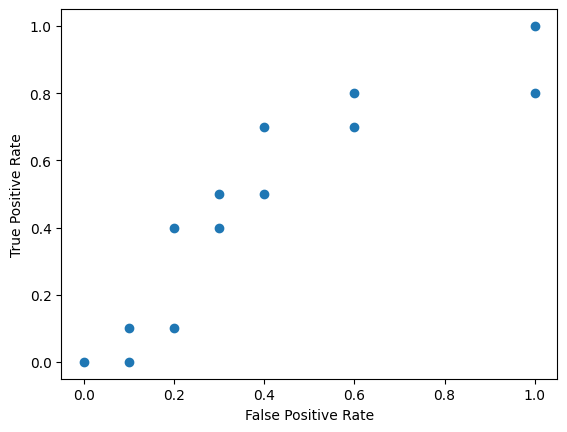

In [ ]:
from sklearn.metrics import roc_curve

#  TODO: use member_label and hist to compute TPR FPR values and generate the scatter plot
fpr, tpr, thresholds = roc_curve(member_label, hist)

plt.scatter(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

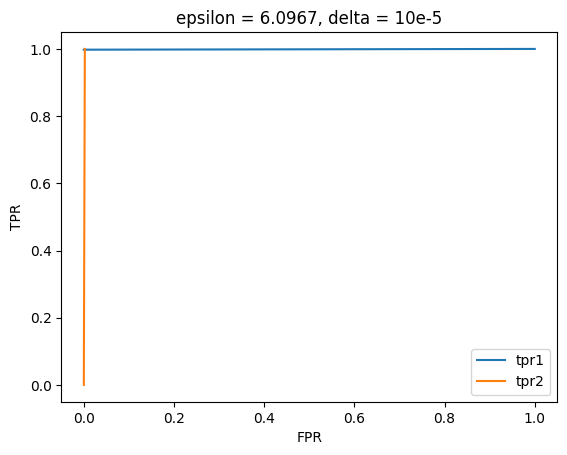

In [41]:
## Plot upper bound for TPR given arbitrary FPR in [0, 1]
import math

eps = 6.0967
# eps =1
delta = 10e-5

fpr1 = [x*0.1 for x in range(11)]
tpr1 = [1 - (1-delta-f)/(math.e**eps) for f in fpr1]

tpr2 = [x*0.1 for x in range(11)]
fpr2 = [(t-delta)/(math.e**eps) for t in tpr2]

plt.plot(fpr1, tpr1, label='tpr1')
plt.plot(fpr2, tpr2, label='tpr2')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('epsilon = 6.0967, delta = 10e-5')
plt.legend()
plt.show()